# Bilan Carbone Datarmor

## Recuperations heures CPU

Denis a envoye un mail contenant les heures CPU pour les utilisateur affilies a Marbec (groupes unix `emeX`, `marbecmd`). Ce mail a ete traite pour mettre les donnees au format CSV. 

Ensuite, le temps CPU mensuel par utilisateur a ete trace:

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

with open('data-datarmor/mail-mickael-2023.txt') as fin:
    lines = fin.readlines()
lines

regex = re.compile('([0-9]{4}) *: *([a-z]+) *: *([0-9]+)')
regex = re.compile('([0-9]{4})')
output = []
for l in lines:
    l = l.strip()
    if regex.match(l):
        temp = l.split(':')
        output.append(temp)

output = np.array(output)
dsout = pd.DataFrame(output[:, 1:])
dsout.columns = ['user', 'cpu']
#dsout['date'] = dsout['date'].astype(int)
dsout['cpu'] = dsout['cpu'].astype(int)
#dsout['year'] = dsout['date'] // 100
# dsout['month'] = dsout['date'] - 100 * dsout['year']
dsout

,user,cpu
0,adupaix,478250353
1,adupaix,324315878
2,adupaix,587545
3,adupaix,59257847
4,adupaix,1814555
...,...,...
187,qschull,626030
188,qschull,315538
189,crestrep,0
190,crestrep,7


In [2]:
dsout_byuser = dsout.groupby(dsout['user']).sum()
dsout_byuser = dsout_byuser.sort_values(by=['cpu'], ascending=False)
dsout_byuser

,cpu
user,
ldalaut,5239118893
mlengaig,3262922665
abrunel,3009418340
vdaniell,2926996476
jrault,2612348007
nbarrier,2575997334
adupaix,866069547
lbald,798163120
mdouille,496117827


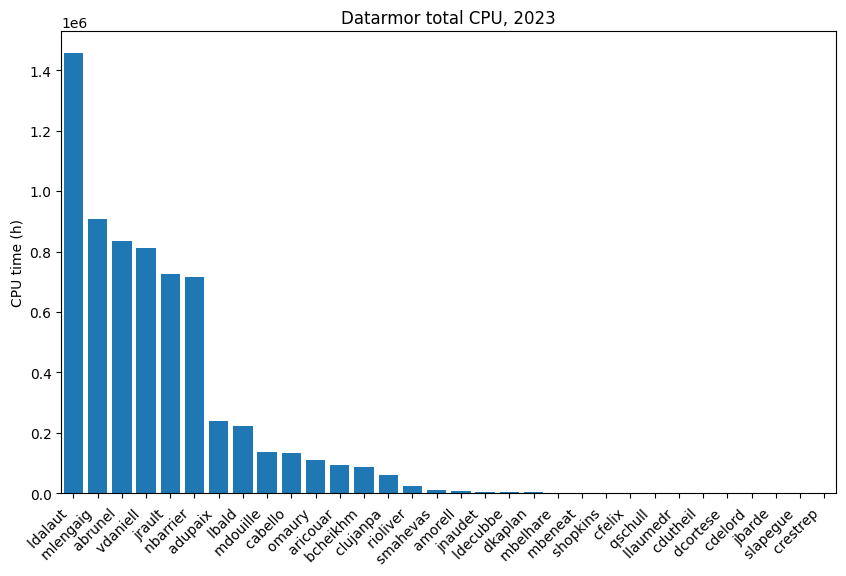

In [3]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
x = np.arange(0, len(dsout_byuser))
plt.bar(x, dsout_byuser['cpu']/ (60 * 60))
ax.set_xticks(x)
ax.set_xticklabels(dsout_byuser.index, rotation=45, ha='right')
ax.set_xlim(x.min() - 0.5, x.max() + 0.5)
ax.set_ylabel('CPU time (h)')
ax.set_title('Datarmor total CPU, 2023')
plt.savefig('datarmor_usage_2023')

## Estimation consomation d'un coeur

La consomation d'une heure CPU a ete estimee a partir des Dashboards Datarmor:

- https://grafana.ifremer.fr/d/000000022/datarmor-diris?orgId=1&from=1672527600000&to=1704063599000
- https://grafana.ifremer.fr/d/000000038/datarmor-pbsacctsql-rapport-exploit?orgId=1&from=1672527600000&to=1704063599000

Ainsi, on a:

In [4]:
ctot = 1.64 * 1e6 # kWh

# Heures CPU totales
cputot = (2003 + 47780 + 17196) * 1000  # conversion kiloheure/heure

# mean = ptot / cputot # conversion from kW
mean = ctot / cputot # en kWh/h donc en kW

#print('Puissance moyenne heure CPU (kW): ', mean)
print('Consommation moyenne heure CPU (kWh): ', mean)

Consommation moyenne heure CPU (kWh):  0.02448528643306111


## Estimation consomation totale

Pour avoir la consomation totale, on somme sur tous les utilisateurs les temps CPU, que l'on multiplie par la consomation moyenne d'un noeud:

In [5]:
# conversion from seconds to hours
conv = 1 / (60 * 60)

# Sum over years
total_cpu = dsout_byuser.sum()

# Sum over users
print('Consomation totale (kWh)')
data = total_cpu * mean * conv
data

Consomation totale (kWh)


cpu    161621.702313
dtype: float64

## Facteurs multiplicatifs

Pour prendre en compte le coût de fabrication et de démantèlement du matériel informatique, on multiplie par le "FCYP" (d'après LOCEAN, en France, 1.42)

In [6]:
fcyp = 1.42
data = data * fcyp

## Consomation de carbone

Pour convertir la consomation en equivalent CO2, on considere qu'en France, 1 kWh est equivalent a 0.1 kg d'equivalent CO2. Ainsi, les emissions sont obtenues en multipliant le tableu precedent par 0.1

In [7]:
conv = 0.1
kg2ton = 1e-3

print('Equivalent CO2 (ton eq. CO2)')
print(data * conv * kg2ton)

Equivalent CO2 (ton eq. CO2)
cpu    22.950282
dtype: float64
